## Quick set-up

Choose one:

- Download from thevirtualbrain.org
- Log into lab.ebrains.eu with EBRAINS account
- Install locally:
    - install [Anaconda](https://www.anaconda.com/products/distribution) or [Miniconda](https://docs.conda.io/en/latest/miniconda.html) Python,
    - setup an env, `conda create -n tvb -y python=3 numpy matplotlib scipy numba numexpr lxml`,
    - activate it, `conda activate tvb`,
    - install TVB packages, `pip install tvb-data tvb-library jupyterlab`,
    - and start the notebook interface, `jupyter lab`

In [1]:
%load_ext autoreload
%autoreload 2

# First steps using TVB

**ABC Summer School, Amsterdam, June 22nd, 2022**

<p align="center">
  <img src="images/tvb-logo.png">
</p>

## Objectives

***

Here we:

* Build a brain network model using subject-specific structural connectivity,
* Simulate resting-state activity,
* Characterize the resting-state activity by calculating the functional connectivity (FC).

## Recipe :  Brain network modeling with TVB

***

### Ingredients
* connectivity 
* node dynamics
* coupling functions
* integrator
* monitors


## How to do it?

***

In the first part of this tutorial, we presents the basic anatomy of a region simulation using The Virtual Brain's scripting interface.

The first thing we want to do is to import the modules we will need for a simulation.


In [31]:
%%capture
import os
import time as tm

import numpy as np
import matplotlib.pyplot as plt

from tvb.simulator.lab import *
from utils import plot_connectivity
from phase_plane import phase_plane_interactive

If anytree module is not installed, install it using

`pip install anytree`


A basic simulation of TVB consists of **5 main components**. Each of these components is an object within TVB:

### Connectivity
***

We start by loading and visualizing the structural connectivity matrix that represents the set of all existing connections between brain areas. Having loaded the default dataset, we can then alter the speed of signal propagation through the network:

![](images/conn-data.jpg)

In [27]:
# Import the anatomical structural connectivity.
conn = connectivity.Connectivity().from_file(
    os.path.abspath('dataset/connectivity_76.zip')
)

In [28]:
nregions = len(conn.region_labels)               # Number of regions
conn.speed = np.array(np.inf)                    # Set the conduction speed
conn.configure()

*Take a look at some of the properties of the `conn` object: `weights`, `delays`, `region_labels`, etc.*

In [29]:
conn

,value
Number of connections,1560
Number of regions,76
Undirected,False
"areas [min, median, max]","[0, 2580.89, 10338.2]"
areas dtype,float64
areas shape,"(76,)"
"tract_lengths (connections) [min, median, max]","[0, 55.8574, 138.454]"
"tract_lengths [min, median, max]","[0, 71.6635, 153.486]"
"tract_lengths-non-zero [min, median, max]","[4.93328, 74.0646, 153.486]"
"weights [min, median, max]","[0, 0, 3]"


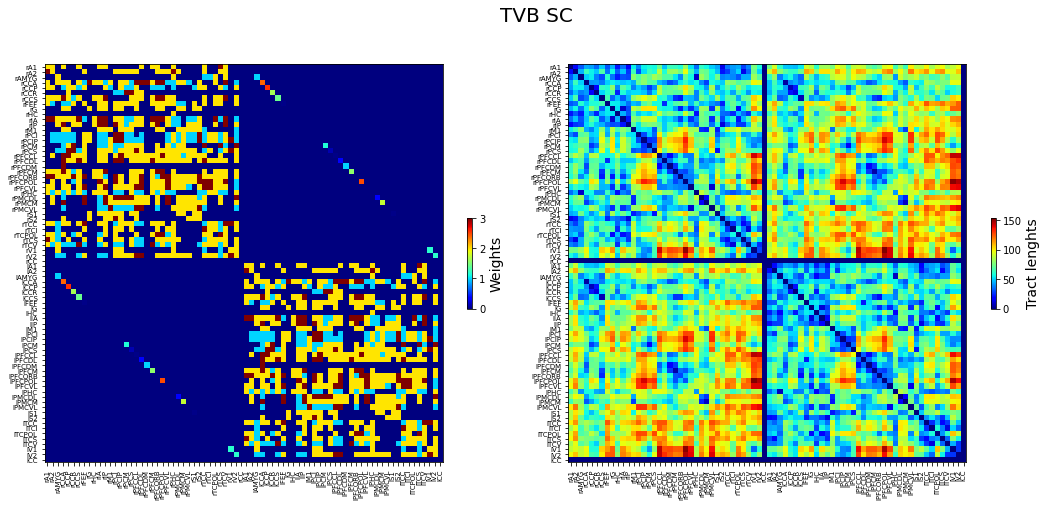

In [30]:
plot_connectivity(conn)

### Model
***

![](images/neural-mass-schema.png)
A set of differential equations describing the local neural dynamics. There are a number of predefined models available in TVB, as an example here we will use the **Generic 2-dimensional Oscillator** model:

\begin{align}
\dot{V} &= d \, \tau (-f V^3 + e V^2 + g V + \alpha W + \gamma I), \\
                \dot{W} &= \dfrac{d}{\tau}\,\,(c V^2 + b V - \beta W + a).
\end{align}

We can explore it using the **phase-plane** tool in TVB.

In [32]:
# Create and launch the phase-plane tool
g2d = models.Generic2dOscillator()                 # The model to investigate
heunint = integrators.HeunDeterministic(dt=1.0)    # Integrator to use.
                                                   # dt is the integration step

phase_plane_interactive(model=g2d, integrator=heunint)


# Try changing the default parameters to
#    1) a = 3   (limit cycle)
#    2) a = 1   (two stable and unstable fixed points)

interactive(children=(FloatSlider(value=1.0, description='tau', max=5.0, min=1.0), FloatSlider(value=0.0, desc…

<function phase_plane.phase_plane_interactive.<locals>.plot_phase_plane(**param_kwargs)>

For our simulation we set it to the limit-cycle regime.

*Note that the parameters of the `Model` class has to be set as numpy arrays.*

In [33]:
# Initialize the model
g2d = models.Generic2dOscillator(a=np.array(1.7402))
g2d

,value
"I [min, median, max]","[0, 0, 0]"
I dtype,float64
I shape,"(1,)"
Type,Generic2dOscillator
"a [min, median, max]","[1.7402, 1.7402, 1.7402]"
a dtype,float64
a shape,()
"alpha [min, median, max]","[1, 1, 1]"
alpha dtype,float64
alpha shape,"(1,)"


### Coupling function
***

![](images/cfun-schema.png)

It is a function that is used to join the local `Model` dynamics at distinct spatial locations over the connections described in `Connectivity`. Proper setting of the parameters for this function requires some knowledge of the properties of both the model being used and the structure through which it is connected. For our present purposes, we happen to know that for this configuration of parameters of TVB's `Generic2dOscillator` connected through TVB's default connectivity matrix, a linear function with a slope of 0.0075 is a reasonable thing to use.

In [36]:
# Initialise a Coupling function.
G = np.array(0.0075)
con_coupling = coupling.Scaling(a=G)

### Integrator
***

Neural mass, coupled with a connectome describe continuous dynamics $f(X)$.  To run on a compute we need an integration scheme,
![](images/int-scheme.jpg)
which allows us to step through time to complete a full simulation.

While TVB supports a number of schemes, for most purposes you should use either `HeunDeterministic` or `HeunStochastic`.

Note that the most important thing here is to use a step size that is small enough for the integration to be numerically stable.

In [37]:
# Initialise an Integrator scheme.
dt = 0.1                          # Integration step [ms]

# We can use the deteministic integrator:
# heunint = integrators.HeunDeterministic(dt=dt)

# Or stochastic integrator:
nsigma = 0.001                    # Standard deviation of the noise
hiss = noise.Additive(nsig=np.array([nsigma, 0]))
heunint = integrators.HeunStochastic(dt=dt, noise=hiss)

### Monitors: forward models in TVB
***
Simulating neural activity is the start of a model in TVB, but linking to neuroimaging data requires forward models of BOLD fMRI, intracranial EEG, EEG and MEG.

![](images/fwd-schema.jpg)




 
A `Monitor` is an observer model. Although there are Monitors which apply a biophysical measurement process to the simulated neural activity, such as EEG, MEG, etc, here we will select two simple monitors to get the time series of the model state variables:

* the `Raw` monitor takes no arguments and simply returns all the simulated data at the time resolution of the integration step,
* the `TemporalAverage` monitor averages over a time window of length period returning one time point every period (given in ms).

*Note: as a general rule, the `Raw` monitor shouldn't be used for anything but very short simulations as the amount of data returned can become prohibitively large*

In [50]:
# Initialise some Monitors with period in physical time.
mon_raw = monitors.Raw()
mon_tavg = monitors.TemporalAverage(period=1)    # 1000 Hz

#Bundle them
what_to_watch = (mon_raw, mon_tavg)

*** 

### Go! Simulate

The last step is to bring all these components together into a `Simulator` object. We then need to run the configure method, which basically just acts to calculate information necessary for the simulation that draws on specific combinations of the components.

In [51]:
# Initialise the Simulator.
sim = simulator.Simulator(model=g2d,
                          connectivity=conn,
                          conduction_speed=np.float(conn.speed),
                          coupling=con_coupling,
                          integrator=heunint,
                          monitors=what_to_watch)
sim.configure()

<ipython-input-51-cc0e28a16923>:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  conduction_speed=np.float(conn.speed),


,value
Type,Simulator
conduction_speed,inf
connectivity,Connectivity gid: 049b2a24-bf93-491b-a25a-ad44acf0580e
coupling,Scaling gid: 467c4f4a-9602-44f9-b893-35b258c7c07b
gid,UUID('5ed820f9-c070-44e7-b328-f70d78cbe420')
initial_conditions,None
integrator,HeunStochastic gid: 1cc38e48-19e2-4905-a612-9eb9f9ef3554
model,Generic2dOscillator gid: 8abdc3f3-0449-42f0-b1d1-b2cab8f05624
monitors,"(, )"
simulation_length,1000.0


Now, we can run the simulation. All we need to do is iterate for some length, which we provide in *ms*, and collect the output. 

The data returned by the simulator is in the form of a list of arrays. For most subsequent purposes it is much easier to deal with the data if it exists as a single contiguous array, hence the enumeration of the return values for the `sim.run`.

In [52]:
# Perform the simulation.
tic = tm.time()

# this should take ~30s
(raw_time, raw_data), (tavg_time, tavg_data) = sim.run(simulation_length=10000.) 

'simulation required %0.3f seconds.' % (tm.time()-tic)

100000it [00:34, 2893.72it/s]                          


'simulation required 34.698 seconds.'

For each monitor, the simulation returns the time points and the associated data array.

The data arrays have shapes $n_\text{timepoints} \times n_\text{variables of interest} \times n_\text{regions} \times n_\text{modes}$.

In [63]:
f"raw_time: {raw_time.shape} | raw_data: {raw_data.shape}" # 10 000 Hz

'raw_time: (100000,) | raw_data: (100000, 1, 76, 1)'

In [64]:
f"tavg_time: {tavg_time.shape} | tavg_data: {tavg_data.shape}" # 1 000 Hz

'tavg_time: (10000,) | tavg_data: (10000, 1, 76, 1)'

In [72]:
np.set_printoptions(suppress=True)
raw_time

array([    0.1,     0.2,     0.3, ...,  9999.8,  9999.9, 10000. ])

In [73]:
tavg_time

array([   0.5,    1.5,    2.5, ..., 9997.5, 9998.5, 9999.5])

***

### Visualize our simulation

And finally, we can look at the results of our simulation in terms of time series. 

In [55]:
# Remove the dimensions with one element for easier indexing
raw = np.squeeze(np.array(raw_data))
tavg = np.squeeze(np.array(tavg_data))
raw.shape, tavg.shape

((100000, 76), (10000, 76))

In [56]:
# Normalize the time series for easier visualization
nraw = raw / (np.max(raw, 0) - np.min(raw, 0))
ntavg = tavg / (np.max(tavg, 0) - np.min(tavg, 0))

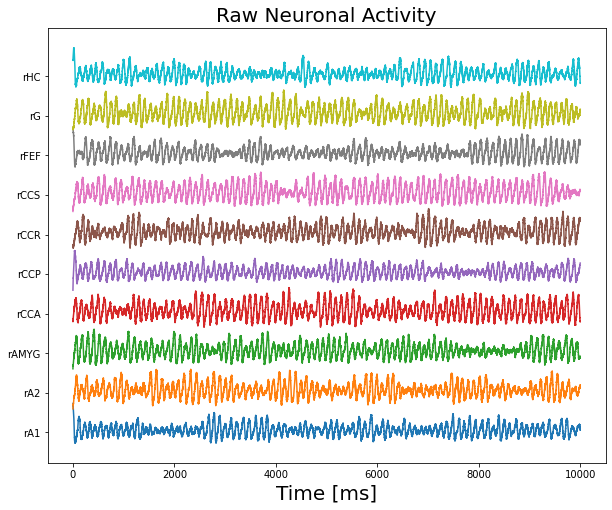

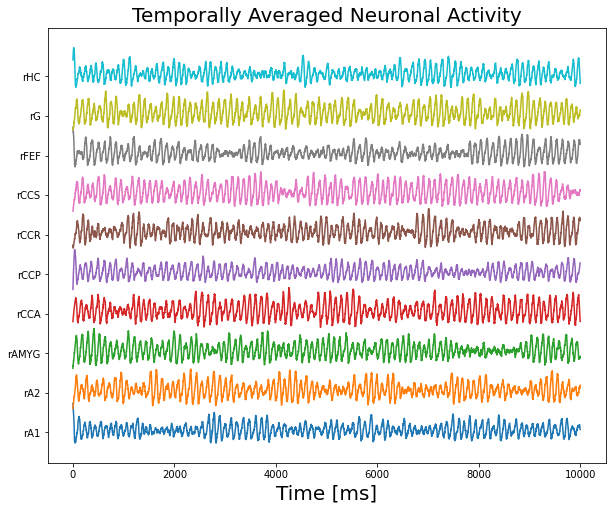

In [57]:
# Plot the raw time series 
fig1 = plt.figure(figsize=(10,8))
plt.plot(raw_time[:], nraw[:, :10] + np.r_[:10])
plt.title('Raw Neuronal Activity', fontsize=20)
plt.xlabel('Time [ms]', fontsize=20)
plt.yticks(range(10), conn.region_labels[:10], fontsize=10)

# Plot the temporally averaged time series
fig2 = plt.figure(figsize=(10,8))
plt.plot(tavg_time[:], ntavg[:, :10] + np.r_[:10])
plt.title('Temporally Averaged Neuronal Activity', fontsize=20)
plt.xlabel('Time [ms]', fontsize=20)
plt.yticks(range(10), conn.region_labels[:10], fontsize=10)

plt.show()

***

# Analysis example: Functional Connectivity (FC)

![](images/coincidence.png)

**Functional Connectivity (FC)** describes the connectedness of two brain regions by means of the covariance between their time series. The classic and most widely used method to infer the strength of network interactions or functional connections consists in estimating the linear (Pearson) correlation coefficient between temporal signals. If two regions activate and deactivate at the same time, there is likely a functional connection. 

To calculate the FC, we ignore the first second of the simulation which might be affected by the initial conditions.

 For a population
 $$ R_{xy} = \frac{ C_{xy} } { \sqrt{ C_{xx} * C_{yy} } } $$
 For a sample 
 $$ r_{xy} =\frac{\sum ^n _{i=1}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum ^n _{i=1}(x_i - \bar{x})^2} \sqrt{\sum ^n _{i=1}(y_i - \bar{y})^2}} $$

In [74]:
fc = np.corrcoef(tavg[1000:].T)

And now we display the resulting FC matrix:

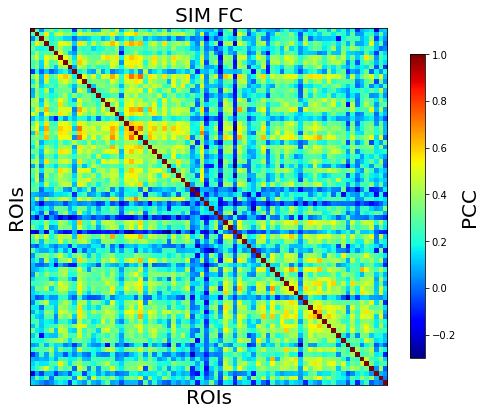

In [22]:
# Visualize FC matrix
plt.figure(figsize=(8,8))
plt.imshow(fc, interpolation='nearest', cmap='jet')
plt.title('SIM FC', fontsize=20)
plt.xlabel('ROIs', fontsize=20); plt.ylabel('ROIs', fontsize=20)
plt.xticks([], fontsize=20); plt.yticks([], fontsize=20)
cb = plt.colorbar(shrink=0.7)
cb.set_label('PCC', fontsize=20)

plt.show()

# What is next? 

* take a look at the BOLD monitor
* introduce external stimulus
* epilepsy use case